In [1]:
import random
import copy
import math

import numpy as np

from numba import jit, njit, cuda, prange

import matplotlib.pyplot as plt

# N-2D Random Walkers With Numpy

In [3]:
generator = np.random.default_rng()
walkers = int(5e3)
n_steps = int(2e3)

In [4]:
steps = generator.random((walkers, n_steps, 2)) - 0.5
steps /= np.abs(steps)

In [5]:
T = np.arange(n_steps + 1)
X = np.insert(np.cumsum(steps, axis=1), 0, 0, axis=1)

In [6]:
x_mean_pos = np.mean(X, axis=0)[:, 0]
y_mean_pos = np.mean(X, axis=0)[:, 1]
mean_squared_dis = np.mean(np.sum(X**2, axis=2), axis=0)

print(f'Mean of Mean Positions At Each Time Step For X = {x_mean_pos.mean()}')
print(f'Mean of Mean Positions At Each Time Step For Y = {y_mean_pos.mean()}')

Mean of Mean Positions At Each Time Step For X = -0.013207996001999001
Mean of Mean Positions At Each Time Step For Y = -0.2944681659170415


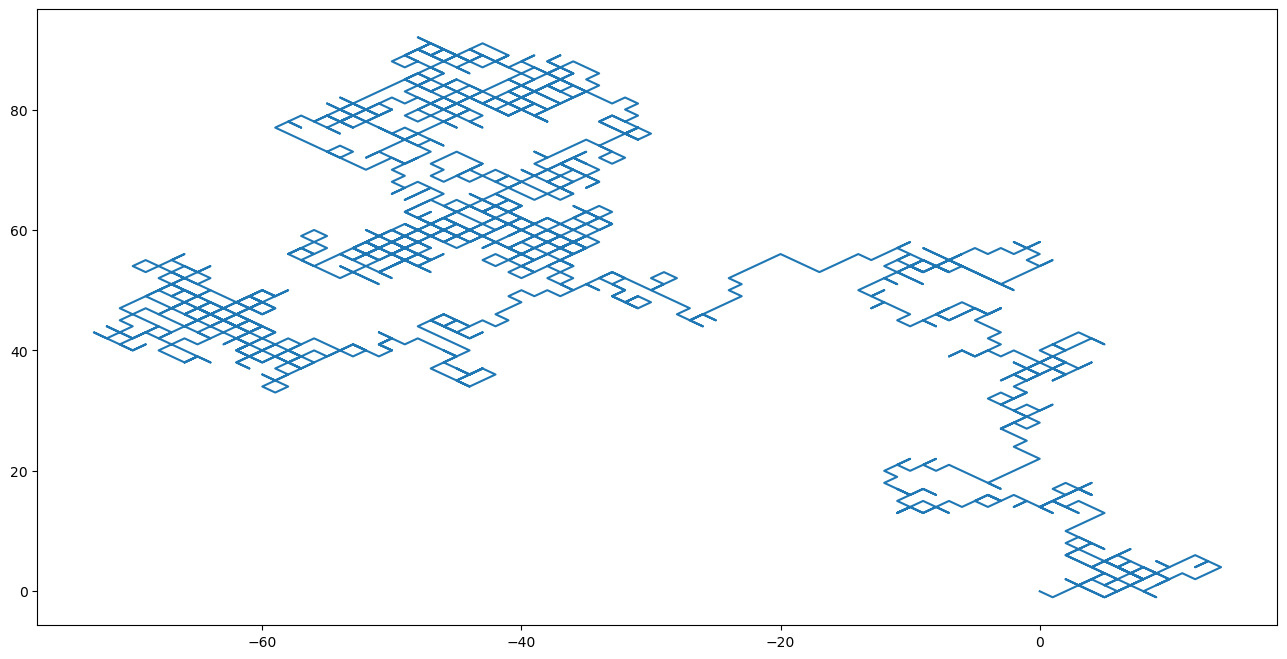

In [7]:
walker_id = 2

plt.figure(figsize = (16, 8))

plt.plot(X[walker_id, :, 0], X[walker_id, :, 1])

plt.show()

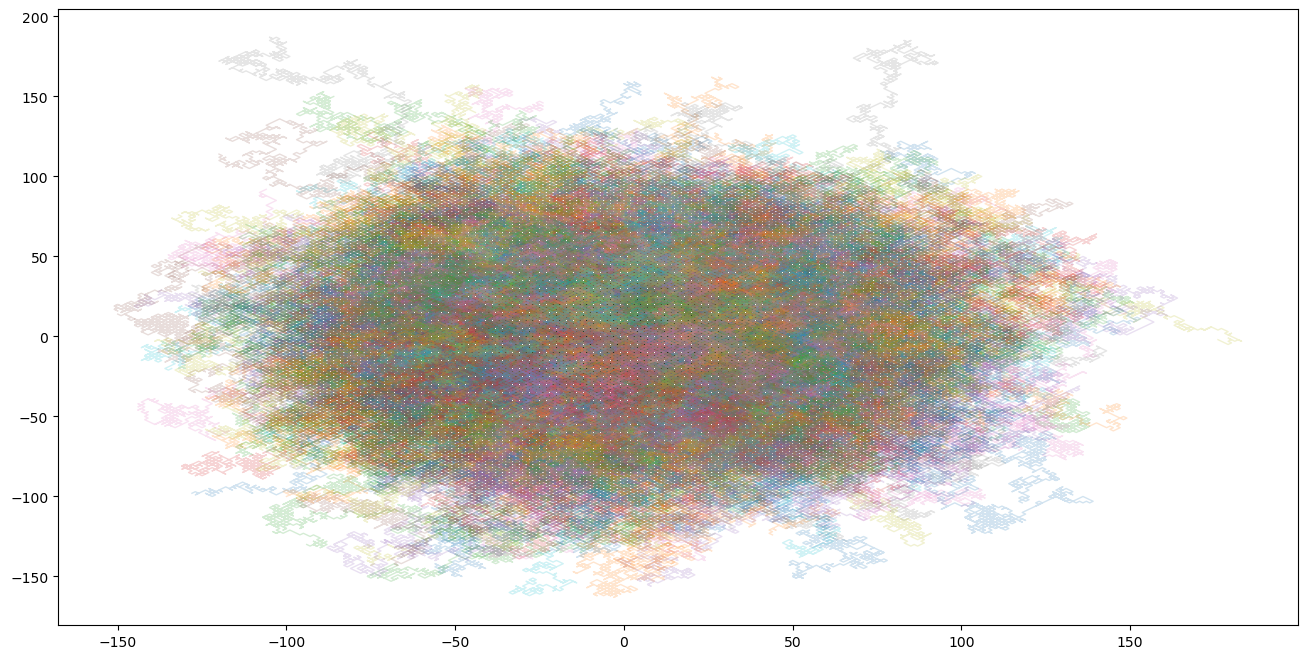

In [8]:
plt.figure(figsize = (16, 8))

for i in range(walkers):
    plt.plot(X[i, :, 0], X[i, :, 1], linewidth=1, alpha=0.2)

plt.show()

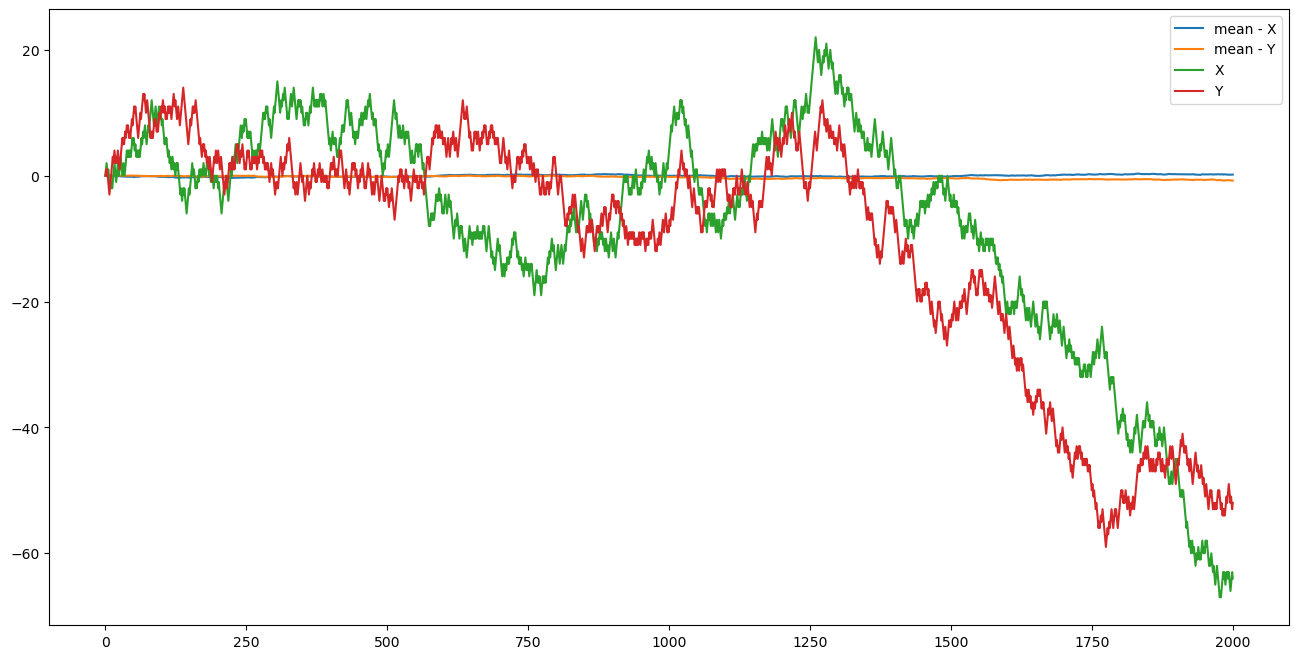

In [9]:
plt.figure(figsize = (16, 8))

plt.plot(T, x_mean_pos, label='mean - X')
plt.plot(T, y_mean_pos, label='mean - Y')

plt.plot(T, X[0, :, 0], label='X')
plt.plot(T, X[0, :, 1], label='Y')

plt.legend()
plt.show()

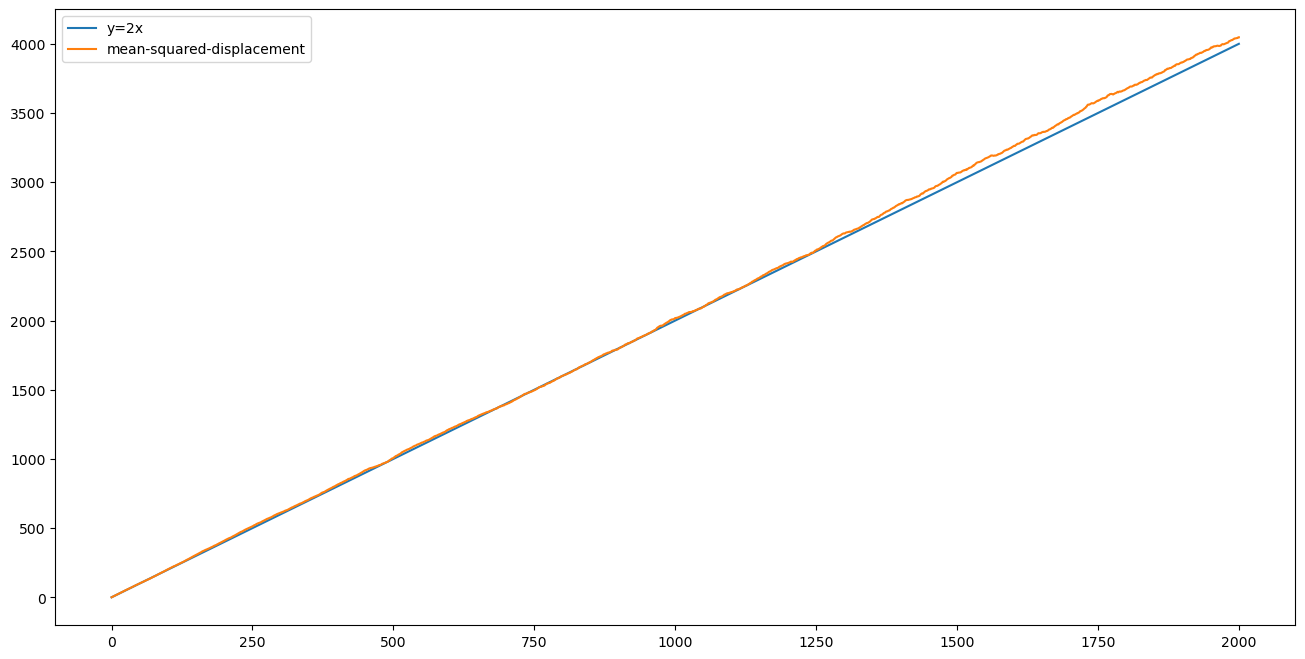

In [10]:
plt.figure(figsize = (16, 8))

plt.plot(T, 2*T, label='y=2x')
plt.plot(T, mean_squared_dis, label='mean-squared-displacement')

plt.legend()
plt.show()

In [11]:
steps_to_reach_zero = np.zeros(walkers)

for i in range(walkers):
    steps_to_reach_zero[i] = np.count_nonzero(np.prod(X[i] == [0, 0], axis=1)) - 1

In [12]:
unique_steps_to_reach_zero = np.unique(steps_to_reach_zero)
appearances_to_reach_zero = np.zeros(len(unique_steps_to_reach_zero))

for i in range(len(unique_steps_to_reach_zero)):
    appearances_to_reach_zero[i] = len(steps_to_reach_zero[steps_to_reach_zero == unique_steps_to_reach_zero[i]])

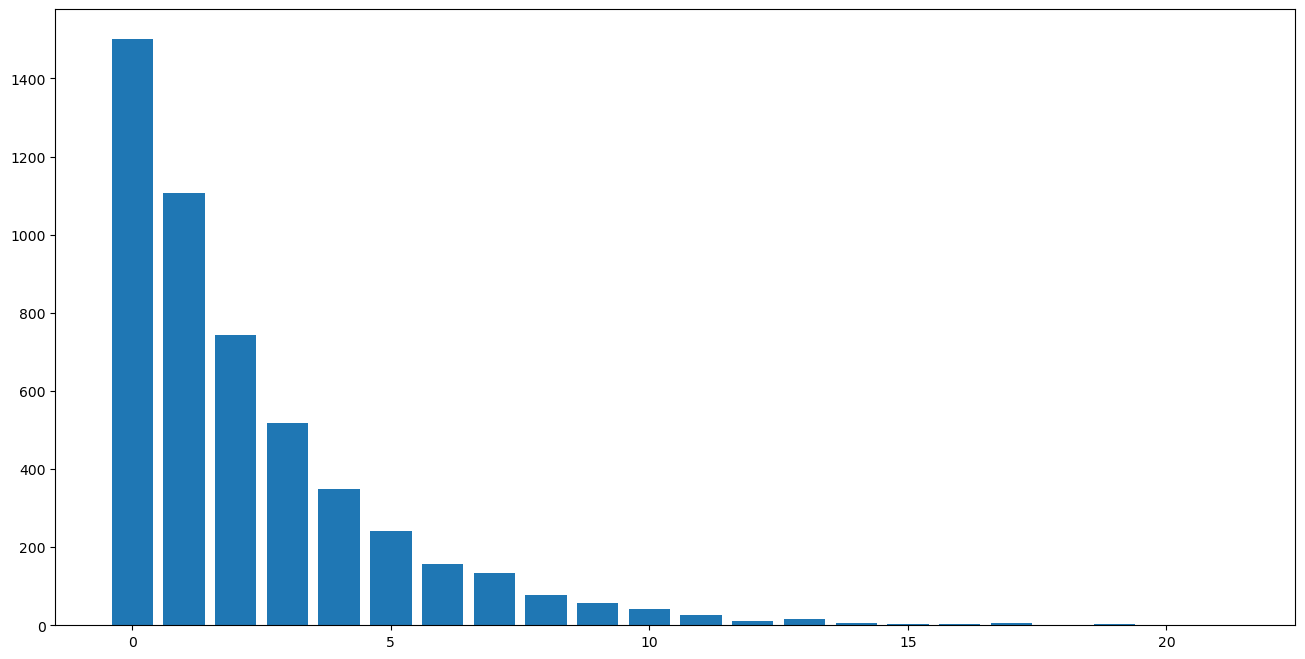

In [13]:
plt.figure(figsize = (16, 8))

plt.bar(x=unique_steps_to_reach_zero, height=appearances_to_reach_zero)

plt.show()

# N-2D Random Walkers With Python & Numba

In [15]:
#@jit(target_backend='cuda') #for nvidia graphic card
@jit
def random_walker_2d(walkers, steps):

    walkers = int(walkers)
    steps = int(steps)
    
    T = [i for i in range(steps + 1)]
    
    random_walks = []
    for j in range(walkers):
    
        X = [0]*(steps+1)
        Y = [0]*(steps+1)
        
        for i in range(steps):
            X_rand = random.uniform(0, 1) - 0.5
            X_rand /= abs(X_rand)
    
            Y_rand = random.uniform(0, 1) - 0.5
            Y_rand /= abs(Y_rand)
        
            X[i+1] = X[i] + X_rand
            Y[i+1] = Y[i] + Y_rand
        
        random_walks.append([X, Y])

    return random_walks

In [16]:
random_walk = random_walker_2d(5e3, 2e4)

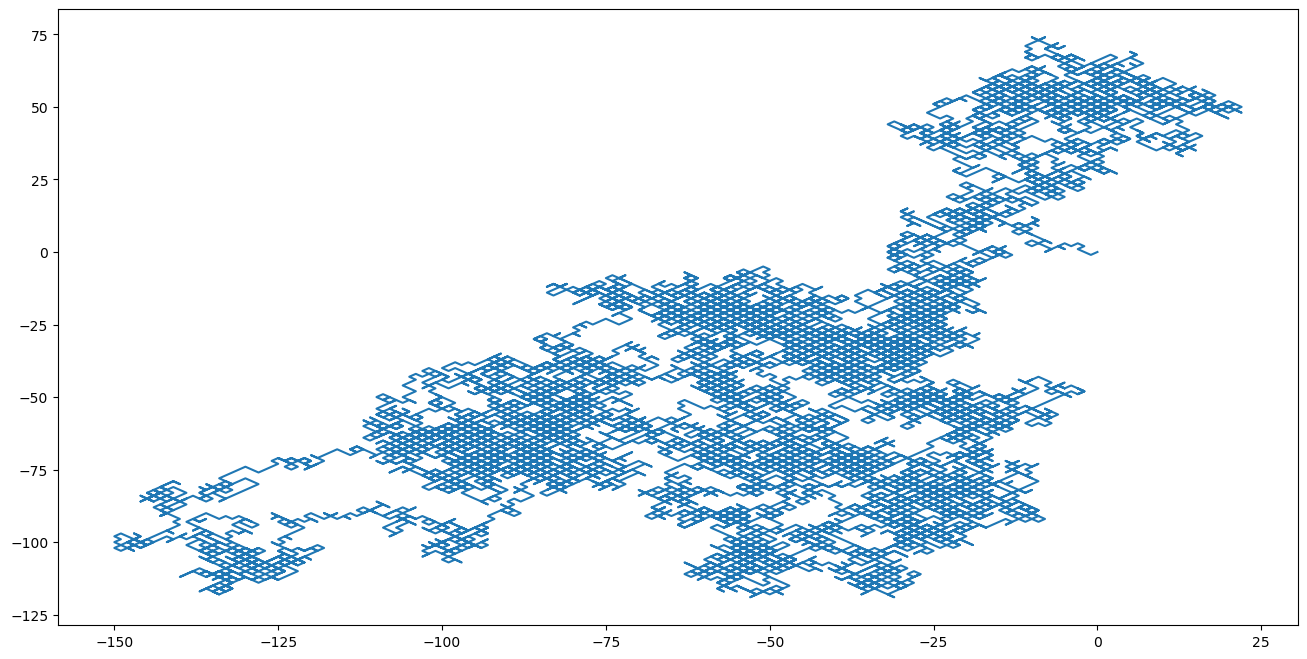

In [17]:
walker_id = -1

plt.figure(figsize = (16, 8))

plt.plot(random_walk[walker_id][0], random_walk[walker_id][1])

plt.show()

# N-2D Random Walkers With Python - Stop When Origin is Reached

In [19]:
#@jit(target_backend='cuda') #for nvidia graphic card
#@jit
def random_walker_2d(walkers, steps):

    walkers = int(walkers)
    steps = int(steps)
    
    #T = [i for i in range(steps + 1)]
    
    random_walks = []
    steps_to_reach_zero = []
    for j in range(walkers):
    
        X = [0]
        Y = [0]

        x = 0
        y = 0
        
        for i in range(steps):
            X_rand = random.uniform(0, 1) - 0.5
            X_rand /= abs(X_rand)
    
            Y_rand = random.uniform(0, 1) - 0.5
            Y_rand /= abs(Y_rand)

            x += X_rand
            y += Y_rand
        
            X.append(x)
            Y.append(y)

            random_walks.append([X, Y])

            if (x, y) == (0, 0):
                steps_to_reach_zero.append(i+1)
                break

            if i == (walkers - 1):
                steps_to_reach_zero.append(math.nan)

    return random_walks, steps_to_reach_zero

In [20]:
walkers = 1e4
steps = 5e3
random_walk, steps_to_reach_zero = random_walker_2d(walkers, steps)

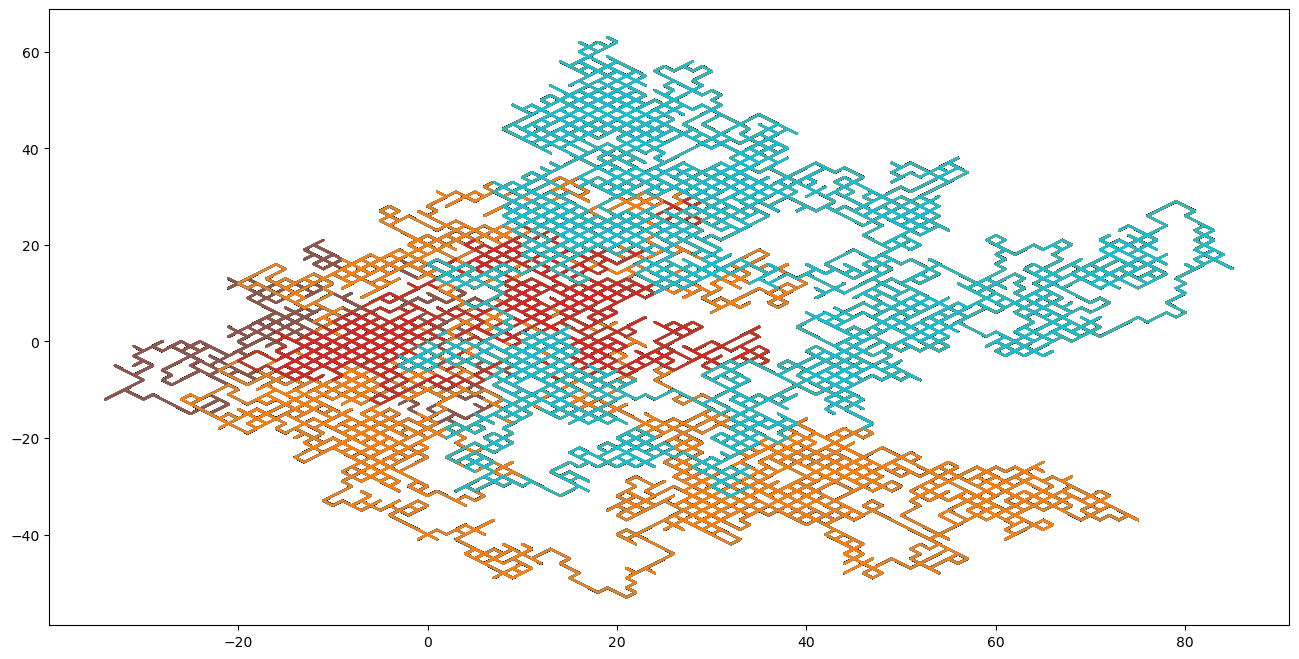

In [21]:
plt.figure(figsize = (16, 8))

for i in range(int(walkers)):
    plt.plot(random_walk[i][0], random_walk[i][1])

plt.show()

In [22]:
steps_to_reach_zero = np.array(steps_to_reach_zero)
unique_steps_to_reach_zero = np.unique(steps_to_reach_zero)
appearances_to_reach_zero = np.zeros(len(unique_steps_to_reach_zero))

for i in range(len(unique_steps_to_reach_zero)):
    appearances_to_reach_zero[i] = len(steps_to_reach_zero[steps_to_reach_zero == unique_steps_to_reach_zero[i]])

In [23]:
int(np.mean(steps_to_reach_zero))

202

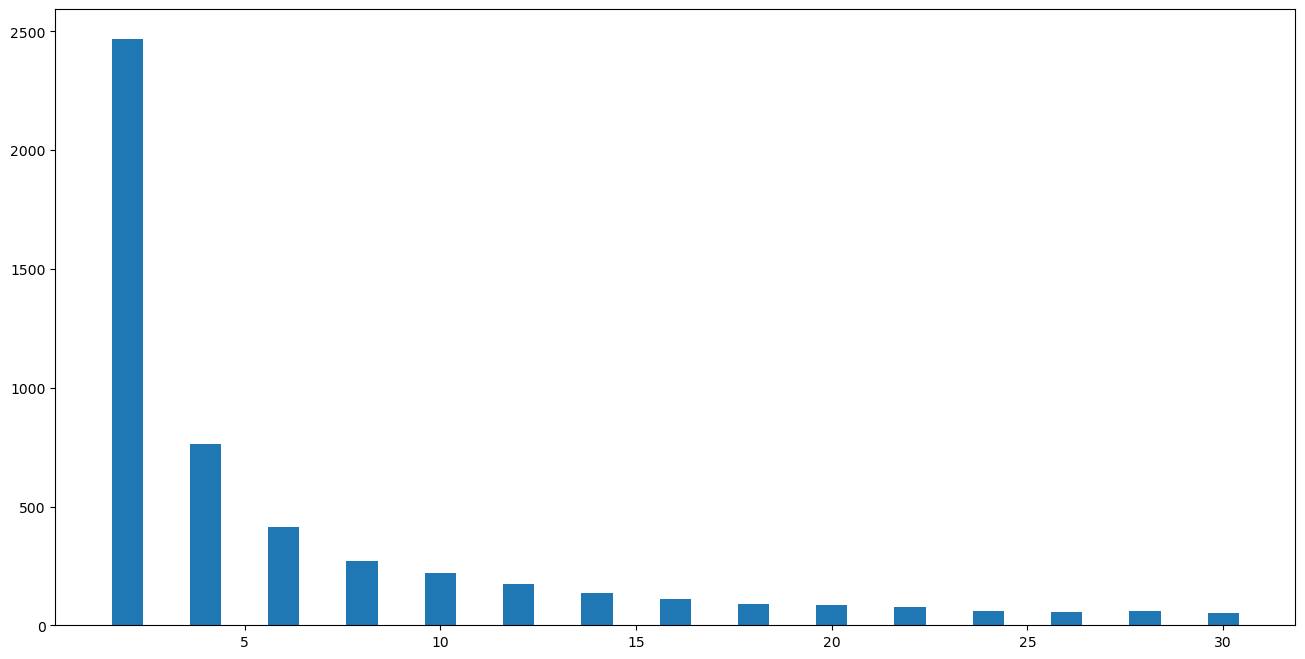

In [24]:
plt.figure(figsize = (16, 8))

plt.bar(x=unique_steps_to_reach_zero[0:15], height=appearances_to_reach_zero[0:15])

plt.show()